In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import sys
import os
from os.path import join
from IPython.display import clear_output

In [2]:
# Download example data
!sct_download_data -d sct_example_data

# Go to MT folder
os.chdir('sct_example_data/mt/')


Trying URL: https://osf.io/kjcgs/?action=download
Status: 100%|##############################| 44.3M/44.3M [00:00<00:00, 44.4MB/s]

Check if folder already exists...
rm -rf sct_example_data

Unzip data to: /Users/julien/code/sct-pipeline/binder-example

Remove temporary file...
Done!



In [3]:
# Jupyter Notebook config
verbose = True # False clears cells

# Folder/filename config
mt_folder = 'binder-example/sct_example_data/mt'
qc_folder ='qc'

t1w = 't1w'
mt0 = 'mt0'
mt1 = 'mt1'
label_c3c4 = 'label_c3c4'
warp_template2anat = 'warp_template2anat'
mtr = 'mtr'
mtsat = 'mtsat'
t1map = 't1map'

file_ext = '.nii.gz'

# Ouputs
results_filename = 'results.csv'

if not verbose:
    clear_output()

In [4]:
# Segment spinal cord
!sct_deepseg_sc -i {t1w+file_ext} -c t1 -qc {qc_folder}

if not verbose:
    clear_output()


Method:
	Centerline algorithm: svm
	Assumes brain section included in the image: True
	Dimension of the segmentation kernel convolutions: 2d

Creating temporary folder...
Reorient the image to RPI, if necessary...
Finding the spinal cord centerline...
Resample the image to 0.5 mm isotropic resolution...
/usr/local/lib/python2.7/site-packages/nipy/io/files.py:145: FutureWarning: Default `strict` currently False; this will change to True in a future version of nipy
  ni_img = nipy2nifti(img, data_dtype = io_dtype)
Cropping the image around the spinal cord...
Normalizing the intensity...
Segmenting the spinal cord using deep learning on 2D patches...
Reassembling the image...
Resampling the segmentation to the original image resolution...
Binarizing the segmentation to avoid interpolation effects...
Remove temporary files...
rm -rf /var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190319124101.431971-SeaDDN
QC: layout with Axial slice
cp /Users/julien/spinalcordtoolbox/spinalcordtoo

['2019_03_19_124105']


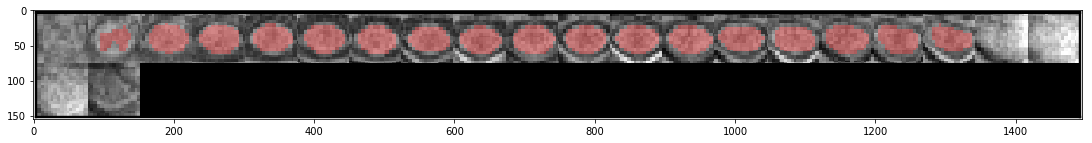

In [18]:
# Plot QC figures

if sys.platform == 'darwin':
    # For local testing on OSX    
    sct_deepseg_sc_qc = 'qc/sct_example_data/mt/sct_deepseg_sc'
else:
    # For linux and on-line Binder execution
    sct_deepseg_sc_qc = join(qc_folder, mt_folder, 'sct_deepseg_sc')

folders = list(filter(lambda x: os.path.isdir(os.path.join(sct_deepseg_sc_qc, x)), os.listdir(sct_deepseg_sc_qc)))
# folders = list(sct_deepseg_sc_qc)
qc_date = max(folders)

sct_deepseg_sc_qc_dir = join(sct_deepseg_sc_qc, qc_date)

bkg=mpimg.imread(join(sct_deepseg_sc_qc_dir, 'bkg_img.png'))
overlay=mpimg.imread(join(sct_deepseg_sc_qc_dir, 'overlay_img.png'))
plt.figure(figsize = (20,2))
imgplot = plt.imshow(bkg)
imgplot = plt.imshow(overlay,alpha=0.3)

In [7]:
# Create mask
!sct_create_mask -i {t1w+file_ext} -p centerline,{t1w+'_seg'+file_ext} -size 35mm -o {t1w+'_mask'+file_ext}

if not verbose:
    clear_output()

  OK: t1w_seg.nii.gz

Create temporary folder (/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214040.348206-create_mask-UFPghK)...

Orientation:
  LPI

Dimensions:
(192, 192, 22, 1, 0.89583331, 0.89583331, 5.000001, 1)

Create mask...

Remove temporary files...
rm -rf /var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214040.348206-create_mask-UFPghK

Done! To view results, type:
fsleyes /Users/julien/code/sct-pipeline/binder-example/sct_example_data/mt/t1w.nii.gz -cm greyscale /Users/julien/code/sct-pipeline/binder-example/sct_example_data/mt/t1w_mask.nii.gz -cm red -a 50.0 &



In [8]:
# Crop data for faster processing
!sct_crop_image -i {t1w+file_ext} -m {t1w+'_mask'+file_ext} -o {t1w+'_crop'+file_ext}

if not verbose:
    clear_output()

/Users/julien/code/sct/bin/isct_crop_image -i t1w.nii.gz -o t1w_crop.nii.gz -start 73,70,4 -end 118,111,20 -dim 0,1,2 # in /Users/julien/code/sct-pipeline/binder-example/sct_example_data/mt
Cropping the following region:
Dimension 0: 73 118
Dimension 1: 70 111
Dimension 2: 4 20

Done! To view results, type:
fsleyes t1w_crop.nii.gz &



In [9]:
# Register PD->T1w
# Tips: here we only use rigid transformation because both images have very similar sequence parameters. We don't want to use SyN/BSplineSyN to avoid introducing spurious deformations.
!sct_register_multimodal -i {mt0+file_ext} -d {t1w+'_crop'+file_ext} -param step=1,type=im,algo=rigid,slicewise=1,metric=CC -x spline

# Register MT->T1w
!sct_register_multimodal -i {mt1+file_ext} -d {t1w+'_crop'+file_ext} -param step=1,type=im,algo=rigid,slicewise=1,metric=CC -x spline

if not verbose:
    clear_output()


Input parameters:
  Source .............. mt0.nii.gz
  Destination ......... t1w_crop.nii.gz
  Init transfo ........ 
  Mask ................ 
  Output name ......... 
  Remove temp files ... 1
  Verbose ............. 1

Check if input data are 3D...

Create temporary folder (/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214051.238094-O5ARO6)...

Copying input data to tmp folder and convert to nii...

--
ESTIMATE TRANSFORMATION FOR STEP #0
Registration parameters:
  type ........... im
  algo ........... syn
  slicewise ...... 0
  metric ......... MI
  iter ........... 0
  smooth ......... 0
  laplacian ...... 0
  shrink ......... 1
  gradStep ....... 0.5
  deformation .... 1x1x0
  init ........... 
  poly ........... 5
  dof ............ Tx_Ty_Tz_Rx_Ry_Rz
  smoothWarpXY ... 2

Estimate transformation
/Users/julien/code/sct/bin/isct_antsRegistration --dimensionality 3 --transform 'syn[0.5,3,0]' --metric 'MI[dest_RPI.nii,src.nii,1,32]' --convergence 0 --shrink-factors 1 

Registering slice 5/16...
isct_antsRegistration --dimensionality 2 --transform 'Rigid[0.5]' --metric 'CC[dest_Z0005.nii,src_Z0005.nii,1,4]' --convergence 10 --shrink-factors 1 --smoothing-sigmas 0mm --output '[warp2d_0005,src_Z0005_reg.nii]' --interpolation 'BSpline[3]' --verbose 1 # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214052.908224-register-jI9XaH
isct_antsRegistration -d 2 -t 'SyN[1,1,1]' -c 0 -m 'MI[dest_Z0005.nii,src_Z0005.nii,1,32]' -o warp2d_null -f 1 -s 0 # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214052.908224-register-jI9XaH
isct_ComposeMultiTransform 2 warp2d_00050Warp.nii.gz -R dest_Z0005.nii warp2d_null0Warp.nii.gz warp2d_00050GenericAffine.mat # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214052.908224-register-jI9XaH
isct_ComposeMultiTransform 2 warp2d_00050InverseWarp.nii.gz -R src_Z0005.nii warp2d_null0InverseWarp.nii.gz -i warp2d_00050GenericAffine.mat # in /private/var/folde

isct_antsRegistration -d 2 -t 'SyN[1,1,1]' -c 0 -m 'MI[dest_Z0012.nii,src_Z0012.nii,1,32]' -o warp2d_null -f 1 -s 0 # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214052.908224-register-jI9XaH
isct_ComposeMultiTransform 2 warp2d_00120Warp.nii.gz -R dest_Z0012.nii warp2d_null0Warp.nii.gz warp2d_00120GenericAffine.mat # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214052.908224-register-jI9XaH
isct_ComposeMultiTransform 2 warp2d_00120InverseWarp.nii.gz -R src_Z0012.nii warp2d_null0InverseWarp.nii.gz -i warp2d_00120GenericAffine.mat # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214052.908224-register-jI9XaH
Registering slice 13/16...
isct_antsRegistration --dimensionality 2 --transform 'Rigid[0.5]' --metric 'CC[dest_Z0013.nii,src_Z0013.nii,1,4]' --convergence 10 --shrink-factors 1 --smoothing-sigmas 0mm --output '[warp2d_0013,src_Z0013_reg.nii]' --interpolation 'BSpline[3]' --verbose 1 # in /private/var/fold


--
ESTIMATE TRANSFORMATION FOR STEP #1

Apply transformation from previous step
sct_apply_transfo -i src.nii -d dest_RPI.nii -w warp_forward_0.nii.gz -o src_reg.nii -x spline # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214110.328997-3c0uCp
Registration parameters:
  type ........... im
  algo ........... rigid
  slicewise ...... 1
  metric ......... CC
  iter ........... 10
  smooth ......... 0
  laplacian ...... 0
  shrink ......... 1
  gradStep ....... 0.5
  deformation .... 1x1x0
  init ........... 
  poly ........... 5
  dof ............ Tx_Ty_Tz_Rx_Ry_Rz
  smoothWarpXY ... 2

Create temporary folder (/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214111.881564-register-p0t5IH)...

Copy input data to temp folder...
sct_convert -i src_reg.nii -o /var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214111.881564-register-p0t5IH/src.nii
sct_convert -i dest_RPI.nii -o /var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-2019030521411

isct_antsRegistration -d 2 -t 'SyN[1,1,1]' -c 0 -m 'MI[dest_Z0006.nii,src_Z0006.nii,1,32]' -o warp2d_null -f 1 -s 0 # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214111.881564-register-p0t5IH
isct_ComposeMultiTransform 2 warp2d_00060Warp.nii.gz -R dest_Z0006.nii warp2d_null0Warp.nii.gz warp2d_00060GenericAffine.mat # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214111.881564-register-p0t5IH
isct_ComposeMultiTransform 2 warp2d_00060InverseWarp.nii.gz -R src_Z0006.nii warp2d_null0InverseWarp.nii.gz -i warp2d_00060GenericAffine.mat # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214111.881564-register-p0t5IH
Registering slice 7/16...
isct_antsRegistration --dimensionality 2 --transform 'Rigid[0.5]' --metric 'CC[dest_Z0007.nii,src_Z0007.nii,1,4]' --convergence 10 --shrink-factors 1 --smoothing-sigmas 0mm --output '[warp2d_0007,src_Z0007_reg.nii]' --interpolation 'BSpline[3]' --verbose 1 # in /private/var/folde

Registering slice 14/16...
isct_antsRegistration --dimensionality 2 --transform 'Rigid[0.5]' --metric 'CC[dest_Z0014.nii,src_Z0014.nii,1,4]' --convergence 10 --shrink-factors 1 --smoothing-sigmas 0mm --output '[warp2d_0014,src_Z0014_reg.nii]' --interpolation 'BSpline[3]' --verbose 1 # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214111.881564-register-p0t5IH
isct_antsRegistration -d 2 -t 'SyN[1,1,1]' -c 0 -m 'MI[dest_Z0014.nii,src_Z0014.nii,1,32]' -o warp2d_null -f 1 -s 0 # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214111.881564-register-p0t5IH
isct_ComposeMultiTransform 2 warp2d_00140Warp.nii.gz -R dest_Z0014.nii warp2d_null0Warp.nii.gz warp2d_00140GenericAffine.mat # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214111.881564-register-p0t5IH
isct_ComposeMultiTransform 2 warp2d_00140InverseWarp.nii.gz -R src_Z0014.nii warp2d_null0InverseWarp.nii.gz -i warp2d_00140GenericAffine.mat # in /private/var/fold

In [10]:
# Create label 4 at the mid-FOV, because we know the FOV is centered at C3-C4 disc.
!sct_label_utils -i {t1w+'_seg'+file_ext} -create-seg -1,4 -o {label_c3c4+file_ext}

if not verbose:
    clear_output()

Label #4: 94,92,11 --> 4


In [ ]:
# Register template->T1w_ax (using template-T1w as initial transformation)
!sct_register_to_template -i {t1w+'_crop'+file_ext} -s {t1w+'_seg'+file_ext} -ldisc {label_c3c4+file_ext} -ref subject -c t1 -param step=1,type=seg,algo=slicereg,metric=MeanSquares,smooth=2:step=2,type=im,algo=bsplinesyn,metric=MeanSquares,iter=5,gradStep=0.5 -qc {qc_folder}

if not verbose:
    clear_output()

Folder qc has been created.

Check template files...
  OK: /Users/julien/code/sct/data/PAM50/template/PAM50_t1.nii.gz
  OK: /Users/julien/code/sct/data/PAM50/template/PAM50_levels.nii.gz
  OK: /Users/julien/code/sct/data/PAM50/template/PAM50_cord.nii.gz

Check parameters:
  Data:                 t1w_crop.nii.gz
  Landmarks:            label_c3c4.nii.gz
  Segmentation:         t1w_seg.nii.gz
  Path template:        /Users/julien/code/sct/data/PAM50
  Remove temp files:    0

Check input labels...

Create temporary folder (/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214135.490992-register_to_template-R6d9sd)...

Copying input data to tmp folder and convert to nii...

Check if provided labels are available in the template

Binarize segmentation
sct_maths -i seg.nii.gz -bin 0.5 -o seg_bin.nii.gz # in /private/var/folders/6f/wy6ljmx9453cgth2qwv5l1s80000gn/T/sct-20190305214135.490992-register_to_template-R6d9sd

Change orientation of input images to RPI...

Remove unused lab

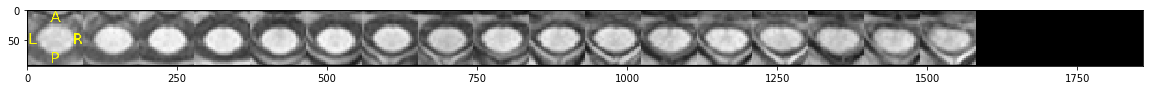

In [11]:
sct_register_to_template_qc = join(qc_folder, mt_folder, 'sct_register_to_template')
folders = list(filter(lambda x: os.path.isdir(os.path.join(sct_register_to_template_qc, x)), os.listdir(sct_register_to_template_qc)))
qc_date = max(folders)

sct_register_to_template_qc_dir = join(sct_register_to_template_qc, qc_date)

bkg=mpimg.imread(join(sct_register_to_template_qc_dir, 'bkg_img.png'))
overlay=mpimg.imread(join(sct_register_to_template_qc_dir, 'overlay_img.png'))
plt.figure(figsize = (20,2))
imgplot = plt.imshow(bkg)
imgplot = plt.imshow(overlay,alpha=0.3)

In [12]:
# Warp template
!sct_warp_template -d {t1w+'_crop'+file_ext} -w {warp_template2anat+file_ext} -qc {qc_folder}

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (master/b6a4f25cd6d728546b1515e4e04145db214945f3)
Running /home/jovyan/work/binder-example/sct/scripts/sct_warp_template.py -d t1w_crop.nii.gz -w warp_template2anat.nii.gz -qc qc
Folder qc has been created.

Check parameters:
  Working directory ........ /home/jovyan/work/binder-example/sct_example_data/mt
  Destination image ........ t1w_crop.nii.gz
  Warping field ............ warp_template2anat.nii.gz
  Path template ............ /home/jovyan/work/binder-example/sct/data/PAM50
  Output folder ............ label


WARP TEMPLATE:
isct_antsApplyTransforms -d 3 -i /home/jovyan/work/binder-example/sct/data/PAM50/template/PAM50_t1.nii.gz -r t1w_crop.nii.gz -t warp_template2anat.nii.gz -o label/template/PAM50_t1.nii.gz -n Linear # in /home/jovyan/work/binder-example/sct_example_data/mt
isct_antsApplyTransforms -d 3 -i /home/jovyan/work/binder-example/sct/data/PAM50/template/PAM50_t2.nii.gz -r t1w_crop.nii.gz -t warp_template2anat.nii.gz -o label/template/PAM50_t2.ni

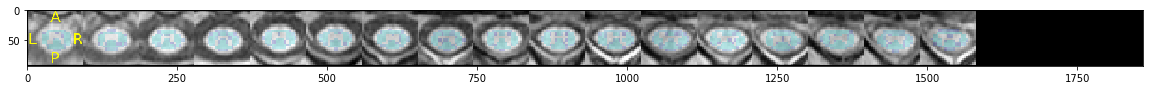

In [13]:
sct_warp_template_qc = join(qc_folder, mt_folder, 'sct_warp_template')
folders = list(filter(lambda x: os.path.isdir(os.path.join(sct_warp_template_qc, x)), os.listdir(sct_warp_template_qc)))
qc_date = max(folders)

sct_warp_template_qc_dir = join(sct_warp_template_qc, qc_date)

bkg=mpimg.imread(join(sct_warp_template_qc_dir, 'bkg_img.png'))
overlay=mpimg.imread(join(sct_warp_template_qc_dir, 'overlay_img.png'))
plt.figure(figsize = (20,2))
imgplot = plt.imshow(bkg)
imgplot = plt.imshow(overlay,alpha=0.3)

In [14]:
# Compute MTR
!sct_compute_mtr -mt1 {mt1+'_reg'+file_ext} -mt0 {mt0+'_reg'+file_ext}

# Compute MTsat and T1
!sct_compute_mtsat -mt {mt1+'_reg'+file_ext} -pd {mt0+'_reg'+file_ext} -t1 {t1w+'_crop'+file_ext} -trmt 57 -trpd 57 -trt1 15 -famt 9 -fapd 9 -fat1 15

if not verbose:
    clear_output()


--
Spinal Cord Toolbox (master/b6a4f25cd6d728546b1515e4e04145db214945f3)
Running /home/jovyan/work/binder-example/sct/scripts/sct_compute_mtr.py -mt1 mt1_reg.nii.gz -mt0 mt0_reg.nii.gz

Create temporary folder (/tmp/sct-20190228013430.451562-zj9Dlt)...

Copying input data to tmp folder and convert to nii...
sct_convert -i mt0_reg.nii.gz -o /tmp/sct-20190228013430.451562-zj9Dlt/mt0.nii
sct_convert -i mt1_reg.nii.gz -o /tmp/sct-20190228013430.451562-zj9Dlt/mt1.nii

Compute MTR...

Generate output files...
sct_convert -i /tmp/sct-20190228013430.451562-zj9Dlt/mtr.nii -o mtr.nii.gz
  File created: mtr.nii.gz

Remove temporary files...
rm -rf /tmp/sct-20190228013430.451562-zj9Dlt
Total processing time: 0 min 2 s


--
Spinal Cord Toolbox (master/b6a4f25cd6d728546b1515e4e04145db214945f3)
Running /home/jovyan/work/binder-example/sct/scripts/sct_compute_mtsat.py -mt mt1_reg.nii.gz -pd mt0_reg.nii.gz -t1 t1w_crop.nii.gz -trmt 57 -trpd 57 -trt1 15 -famt 9 -fapd 9 -fat1 15
Load data...
Compute T1 

In [15]:
# Extract MTR, MTsat and T1 in WM between C2 and C4 vertebral levels
!sct_extract_metric -i mtr.nii.gz -l 51 -vert 2:4 -o {results_filename}
!sct_extract_metric -i mtsat.nii.gz -l 51 -vert 2:4 -o {results_filename} -append 1
!sct_extract_metric -i t1map.nii.gz -l 51 -vert 2:4 -o {results_filename} -append 1



--
Spinal Cord Toolbox (master/b6a4f25cd6d728546b1515e4e04145db214945f3)
Running /home/jovyan/work/binder-example/sct/scripts/sct_extract_metric.py -i mtr.nii.gz -l 51 -vert 2:4 -o results.csv

Load metric image...
Estimation for label: white matter

File created: results.csv
Total processing time: 0 min 3 s


--
Spinal Cord Toolbox (master/b6a4f25cd6d728546b1515e4e04145db214945f3)
Running /home/jovyan/work/binder-example/sct/scripts/sct_extract_metric.py -i mtsat.nii.gz -l 51 -vert 2:4 -o results.csv -append 1

Load metric image...
Estimation for label: white matter

File created: results.csv
Total processing time: 0 min 4 s


--
Spinal Cord Toolbox (master/b6a4f25cd6d728546b1515e4e04145db214945f3)
Running /home/jovyan/work/binder-example/sct/scripts/sct_extract_metric.py -i t1map.nii.gz -l 51 -vert 2:4 -o results.csv -append 1

Load metric image...
Estimation for label: white matter

File created: results.csv
Total processing time: 0 min 4 s

